# *MATH2319 Machine Learning*

# Semester 1, 2021



# Report Overview <a name="RO"></a>

- [Introduction](#Intro)
- [Report Overview](#RO)
- [Overview of Methodology](#OM)
- [Data Pre-processing for Model Evaluation](#DP)
- [Predictive Modelling](#PM)
  + [Feature Selection](#FS)
  + [Model Fitting & Tuning](#MFT)
    + [KNN Model](#KNN)
    + [Naive Bayes](#NB)
    + [Decision Tree](#DT)
    + [Random Forest Classifier](#RF)
  + [Model Comparision](#MC)
- [Critique & Limitations](#CL)
- [Summary & Conclusions](#SC)
  + [Project Summary](#PS)
  + [Summary of Findings](#SF)
  + [Conclusions](#C)
- [References](#R)

# Introduction <a name="Intro"></a>

The objective of this case study is to predict the credit card default of clients based in Taiwan. This research aims at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default using various methods.

This dataset includes information on default charges, demographic characteristics, credit records, payment history, and bill statements for credit card clients in Taiwan from April 2005 to September 2005.The data set is derived from the [UCI Machine Learning Repositry](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).<br>


# Overview of Methodology <a name="OM"></a>

The default of credit card clients dataset which we explored in Phase 1 will be further transformed as appropriate for machine learning. This includes encoding the target feature and normalising the dataset using Min-Max Scaler. <br>

Following the normalisation of the dataset, steps will be taken to minimise the number of descriptive features by selecting the optimum features through Random Forest Information feature selection method. We consider 10, 20, and the entire set of features (24 features).Using feature selection and hyperparameter search inside a single pipeline, we execute a 5-fold stratified cross-validation to fine-tune each classifier's hyperparameters using Area under curve 'roc-auc' as the performance metric.<br>

The dataset is then split into 70:30 training and testing subsets. Model evaluation is performed first on training data to define the ideal parameters, and then on testing data to assess performance accuracy.

Model evaluation is proceeded with the the best feature selection method on the following models:

- K-Nearest Neighbours (KNN)
- Logistic Regression (LR)
- Decision Trees (DT)
- Naive Bayes (NB)
- Random Forest Classifier (RF)

Performance comparison will be conducted on the models with the application of a paired t-test.

Confusion matrices are ascertained to determine the outcome of each predictive model.

# Data Pre-processing for Model Evaluation <a name="DP"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px
import altair as alt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:

df = pd.read_csv('Phase1_df.csv',index_col=[0] )
df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,3,3,-1,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,3,1,1,1,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,1,1,1,1,1,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,1,1,1,1,1,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,1,-1,1,1,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


"default.payment.next.month" is a categorical feature and is hence converted into numeric by storing default payment as '1' and no default payment as '0'

In [3]:
df1 = df.drop(columns='default.payment.next.month')
target = df['default.payment.next.month']
target.value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [4]:
np.unique(target, return_counts=True)

(array([0, 1], dtype=int64), array([23364,  6636], dtype=int64))

In [5]:
target1 = pd.DataFrame(target)

Changing the column types to int 64 for predictive modelling.

In [6]:
for col in ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6','PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4' , 'PAY_AMT5', 'PAY_AMT6']:
    df1[col] = df1[col].astype('int64')

Checking any missing values

In [7]:
df1.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

### *Note that the One Hot encoding of the descriptive features is not done separately as the features in the dataset are already encoded*

### Scaling of Features

A min-max scaling of the descriptive features is performed.

In [8]:

from sklearn import preprocessing

Data_df = df1.copy()

Data_s = preprocessing.MinMaxScaler()
Data_s.fit(df1)
Data = Data_s.fit_transform(df1)


## Feature Selection <a name="FS"></a>

Let's take a look at the top 10 features in the complete dataset as determined by Random Forest Importance (RFI). This is for a fast ranking of the top ten features to acquire insight into the issue at hand. We will add RFI as part of the pipeline during the hyperparameter tuning phase, and we will search over 10, 20, and the entire set of 24 characteristics to discover which number is best.

In [9]:
from sklearn.ensemble import RandomForestClassifier

num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi =Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['PAY_0', 'AGE', 'BILL_AMT1', 'LIMIT_BAL', 'BILL_AMT2', 'BILL_AMT3',
       'PAY_AMT1', 'BILL_AMT4', 'BILL_AMT6', 'BILL_AMT5'], dtype=object)

In [10]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.09198522, 0.06716771, 0.06140139, 0.06001714, 0.05522911,
       0.05312338, 0.0528653 , 0.05186835, 0.05109359, 0.05062138])

Let's visualize these importances.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

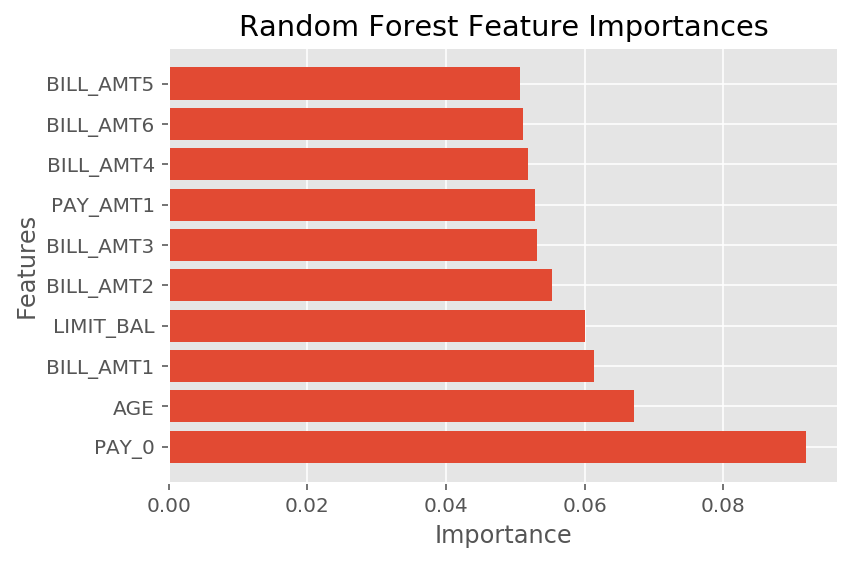

In [12]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest')

We observe that the most important feature is "Pay_0" followed by 'Age', 'BILL_AMT1', 'LIMIT_BAL', 'BILL_AMT2', 'BILL_AMT3',and 'PAY_AMT1'

# Predictive Modelling <a name="PM"></a>

The following models are evaluated to determine which is the best predictive model to determine a credit card defaults.

- KNN Model
- Logistic Regression
- Naive Bayes
- Decision Tree


The scoring metric 'ROC-AUC' is utilised to determine the performance score of each model on the data which is split into testing and training data.
A paired t-test is then conducted to finalise on the best model based on their performance score on the testing data to determine if the models scores are statistically significant or not

### Data Sampling & Train-Test Splitting

The data is split into a 7:3 ratio with 70% of the data used for training and 30% of the data used for testing. The main purpose of splitting the data is to avoid overfitting and also to determine how well the model performs on new data(testing data)

In [13]:
from sklearn.model_selection import train_test_split

Data_train, Data_test, \
target_train, target_test = train_test_split(Data, target, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target)

print(Data_train.shape)
print(Data_test.shape)

(21000, 23)
(9000, 23)


###  Cross Validation
To avoid the occurrence of an impartial split, which would jeopardise the credibility of model selection, a 5 fold cross validation with 3 repeats is used.

As a result, the percentage of good and poor risk in the dataset is not equal. To ensure that there is no biassed analysis, RepeatedStratifiedKFold is used to guarantee that the proportion of the target variables remains the same for each split for each model assessment. The seed is set to 999 to ensure that the same data is picked each time.

In [103]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method = StratifiedKFold(n_splits=5, random_state=999)

## Model Fitting & Tuning <a name="MFT"></a>

### Model Evaluation Strategy

So, we will train and tune our models on 21K rows of training data and we will test them on 9K rows of test data. For each model, we will use 5-fold stratified cross-validation evaluation method (without any repetitions for shorter run times) for hyperparameter tuning.

### Hyperparameter Tunning
To discover the best settings for each model, hyperparameter tuning is used. Pipeline code is used to optimise the settings of Random Forest Importance and the model. The performance score is determined by the scoring measure 'Accuracy.'


### K-Nearest Neighbors (KNN) <a name="KNN"></a>

Pipeline is used to stack feature selection and grid search for KNN hyperparameter tuning using cross-validation. For NB and DT, we will utilize the same Pipeline technique. The KNN hyperparameters are: number of neighbours (n neighbors) and distance metric p.<br>

We apply the powerful Random Forest Importance (RFI) approach with 100 estimators for feature selection. A challenge here is that we need some scripting to make RFI feature selection part of the flow. As a result, we construct the custom RFIFeatureSelector() class below to input RFI into the pipeline as a "step."

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# code used from feature ranking notes
# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                   'knn__n_neighbors': [1, 5, 10, 15, 20],
                   'knn__p': [1, 2]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='roc_auc',
                           verbose=1) 

The pipeline code below illustrates the best number of features to choose from a list of 10, 20, and entire dataset features.
The optimal number of nearest neighbours and distance metric when employing a repeated stratified k fold with 'Accuracy' as the scoring metric.

In [46]:
gs_pipe_KNN.fit(Data_train, target_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed: 12.5min finished


The optimal number of neighbours is 20 and the optimal number of features to be selected for KNN model is the full dataset features i.e 20.

In [48]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 20, 'knn__p': 1, 'rfi_fs__n_features_': 20}

In [49]:
gs_pipe_KNN.best_score_

0.7434714302779523

We find that the best KNN model has a mean AUC score of 0.743. The top performing KNN chose 20 features with 20 nearest neighbours and p=1, the Manhattan distance.
Despite the fact that these are the best numbers, let's have a look at the other combinations to determine whether the difference is substantial. To do so, we'll utilise the function below to format the grid search outputs as a Pandas data frame.

In [50]:
# custom function to format the search results as a Pandas data frame
# code from feature ranking notes
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [101]:
KNN_results = get_search_results(gs_pipe_KNN)
KNN_results.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
25,0.743471,0.002849,0.746612,0.738436,20.0,1.0,20.0
28,0.741040,0.005033,0.745733,0.731316,20.0,2.0,20.0
19,0.740858,0.005920,0.744716,0.729192,15.0,1.0,20.0
22,0.737952,0.006104,0.743727,0.727430,15.0,2.0,20.0
26,0.734094,0.005582,0.743682,0.726572,20.0,1.0,23.0


We observe that the difference between the hyperparameter combinations is not really much when conditioned on the number of features selected. Let's visualize the results of the grid search corresponding to 10 selected features.

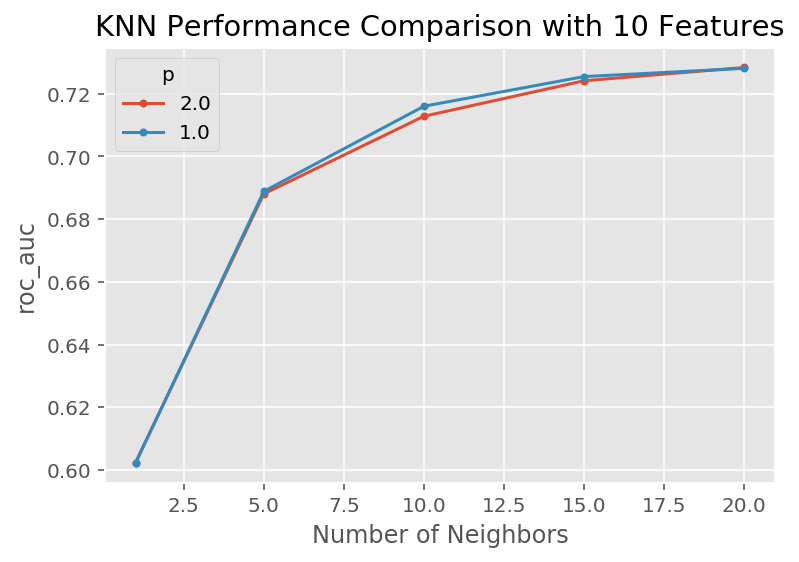

In [100]:
KNN_results_10_features = KNN_results[KNN_results['rfi_fs__n_features_'] == 10.0]

for i in KNN_results_10_features['knn__p'].unique():
    temp = KNN_results_10_features[KNN_results_10_features['knn__p'] == i]
    plt.plot(temp['knn__n_neighbors'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "p")
plt.xlabel('Number of Neighbors')
plt.ylabel("roc_auc")
plt.title("KNN Performance Comparison with 10 Features")
plt.show()

### Logistic Regresssion

Logistic Regression is a Machine Learning technique that is used for classification issues; it is a predictive analytic approach that is based on the probability notion. 
Below we defined logistic regression to fit the training data to find the AUC of the model

In [53]:
def logistic_regression(imbalance=False):
    
    lr = LogisticRegression(random_state=42)
    
    # Fitting the model
    lr.fit(Data_train, target_train)

    # Using model's default parameters for cross validation score
    cv = cross_val_score(lr, Data_train, target_train, scoring ="roc_auc", cv = cv_method)
    accuracy_lr = np.mean(cv)

#### Tuning parameters of Logistic Regression

In [54]:
# A randomised search for the optimal C parameter is performed.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

logr = LogisticRegression(solver='saga', tol=1e-2, max_iter=100,random_state=34)
dist = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
lr_cf = RandomizedSearchCV(logr, dist, random_state=42)

best_lr= lr_cf.fit(Data_train, target_train)   

print(best_lr.best_params_)

{'C': 3.329770563201687, 'penalty': 'l1'}


In [64]:
#Get Accuracy score of tuned model on training data

lr_tuned = cross_val_score(best_lr, Data_train, target_train, scoring = "roc_auc", cv = cv_method)
roc_lr_best = np.mean(lr_tuned)

roc_lr_best

0.7125224803941345

We find that the best AUC score of Logistic Regression Model is 0.712. 

In [65]:
lr_results = get_search_results(best_lr)
lr_results.head()

,mean_score,std_score,max_score,min_score,C,penalty
8,0.803,0.00362218,0.809286,0.799524,3.32977,l1
6,0.802952,0.00366574,0.809286,0.799524,2.83229,l1
5,0.802524,0.00350445,0.808333,0.798333,1.33483,l1
3,0.802333,0.00373256,0.808333,0.798333,1.78333,l2
0,0.802286,0.00358442,0.808095,0.798333,1.49816,l2


We observe that the difference between the hyperparameter combinations is not really much when conditioned on the parameters. Let's visualize the results of the grid search corresponding selected features.

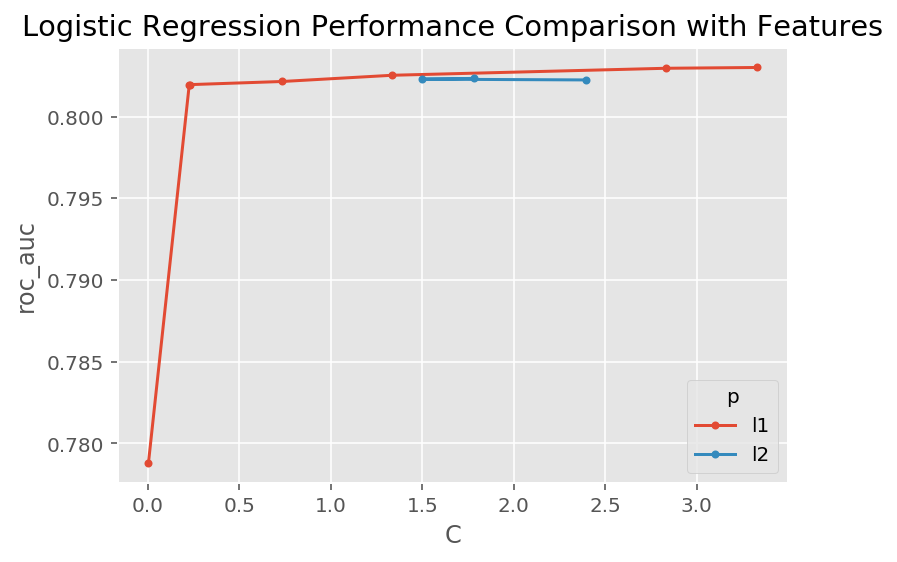

In [75]:
for i in lr_results['penalty'].unique():
    temp = lr_results[lr_results['penalty'] == i]
    plt.plot(temp['C'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "p")
plt.xlabel('C')
plt.ylabel("roc_auc")
plt.title("Logistic Regression Performance Comparison with Features")
plt.show()

### Gaussian Naive Bayes (NB) <a name="NB"></a>

Gaussian Naive Bayes model analyses data under the premise that it is normally distributed. Because this is not always the case with real-world data, Power transformation is used to bring the data closer to a normal distribution.

Sklearn's PowerTransformer,preprocessing is utilised to conduct the power transformation.


In [67]:
from sklearn.preprocessing import PowerTransformer
Data_tt = PowerTransformer().fit_transform(Data_train)
Data_ttest = PowerTransformer().fit_transform(Data_test)

When training a Naive Bayes model, the pipeline code below is used to find the ideal number of features and variable smoothing.

In [68]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-3, num=200)}

n_iter_search = 20
gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          n_iter=n_iter_search,
                          verbose=1) 

gs_pipe_NB.fit(Data_tt, target_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:  6.6min finished


Naive Bayes model shows the ideal number of features as 23

In [69]:
gs_pipe_NB.best_params_

{'rfi_fs__n_features_': 23, 'nb__var_smoothing': 0.0027682866303920667}

The performance score of Naive Bayes model with 23 features is 0.719

In [70]:
gs_pipe_NB.best_score_

0.7193256523468955

A dataframe grid is generated below to display the performance scores with varying numbers of features and var smoothing values and to determine if the results are significantly different or not.

In [73]:
NB_results = get_search_results(gs_pipe_NB)
NB_results.head()

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
14,0.719326,0.008594,0.729768,0.707381,23.0,0.002768
11,0.719271,0.008546,0.729619,0.707352,23.0,0.015344
7,0.719232,0.008515,0.729526,0.707336,23.0,0.022219
19,0.718805,0.008234,0.728544,0.707138,23.0,0.097712
4,0.718062,0.009197,0.730021,0.705162,20.0,0.004398


From the table above is it observed that 23 is the most ideal number of features to be selected.

Let's visualize the search results.

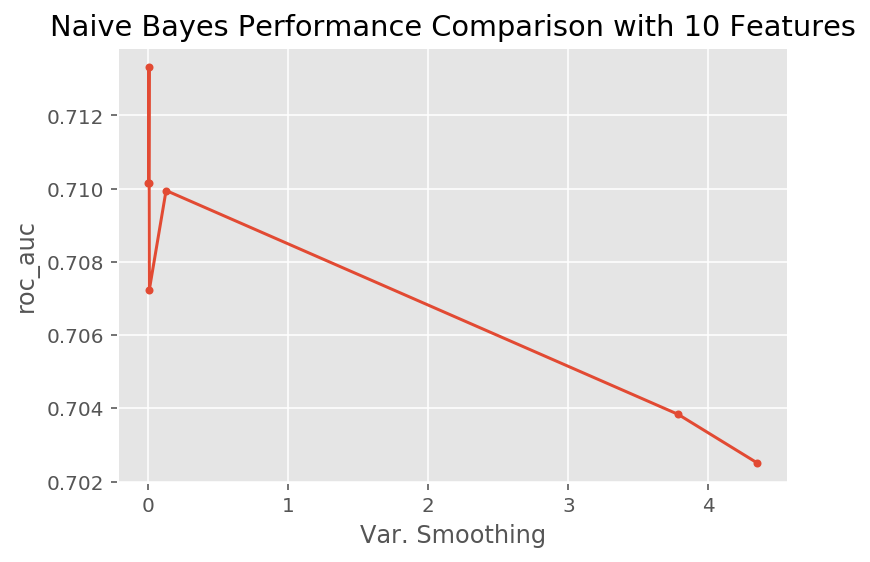

In [99]:
NB_results_10_features = NB_results[NB_results['rfi_fs__n_features_'] == 10.0].sort_values('nb__var_smoothing')

plt.plot(NB_results_10_features['nb__var_smoothing'], NB_results_10_features['mean_score'], marker = '.', label = i)    
plt.xlabel('Var. Smoothing')
plt.ylabel("roc_auc")
plt.title("Naive Bayes Performance Comparison with 10 Features")
plt.show()

### Decision Trees (DT) <a name="DT"></a>

A pipeline is built to identify the best parameters for the RFI and DT models. When implementing the DT model, RFI is fitted to identify the ideal amount of features. DT's maximum depth is set to 3, 4, and 5. The minimum sample split is set to 2 and the maximum sample split is set to 5.

In [78]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=111))])

params_pipe_DT = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'dt__max_depth': [3, 4, 5],
                  'dt__min_samples_split': [2, 5]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT.fit(Data_train, target_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:  6.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=999, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rfi_fs',
                                        RFIFeatureSelector(n_features_=10)),
                                       ('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split...
             

The optimum maximum depth is 5, the optimum minimum sample split is 5, and the ideal number of features is 20.

In [80]:
gs_pipe_DT.best_params_

{'dt__max_depth': 5, 'dt__min_samples_split': 5, 'rfi_fs__n_features_': 20}

The AUC of DT with 20 features is 0.753

In [81]:
gs_pipe_DT.best_score_

0.7537803425674757

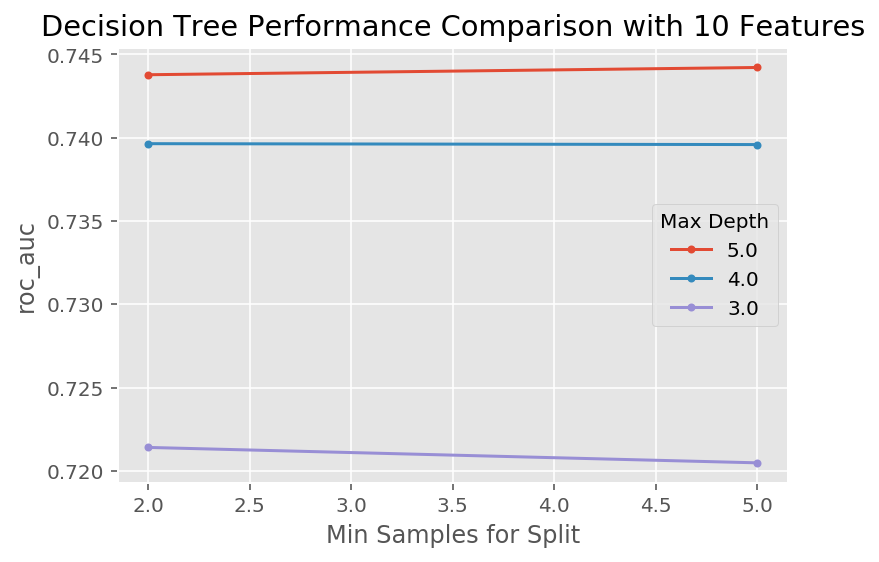

In [98]:
DT_results = get_search_results(gs_pipe_DT)
DT_results_10_features = DT_results[DT_results['rfi_fs__n_features_'] == 10.0]


for i in DT_results_10_features['dt__max_depth'].unique():
    temp = DT_results_10_features[DT_results_10_features['dt__max_depth'] == i]
    plt.plot(temp['dt__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "Max Depth")
plt.xlabel('Min Samples for Split')
plt.ylabel("roc_auc")
plt.title("Decision Tree Performance Comparison with 10 Features")
plt.show()

Above is a graphical depiction of the grid dataframe with number of features=20. Because max depth 5 has the maximum AUC, more fine tuning is performed to see whether reducing the depth may result in a more perfect model.

### Further Fine Tuning
We note that the best value for the maximum depth hyperparameter is at the very edge of its search area. As a result, we must go above and beyond what we have previously attempted to ensure that we do not lose out on even greater values. As a result, we will do a new search, as shown below.

In [83]:
params_pipe_DT2 = {'rfi_fs__n_features_': [10],
                  'dt__max_depth': [1, 2, 3],
                  'dt__min_samples_split': [5, 50, 100, 150]}

gs_pipe_DT2 = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT2, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT2.fit(Data_train, target_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:  3.7min finished


As suspected, we can achieve slightly better results with the new search space. Max depth of 3 is more ideal than max depth of 5 with 10 features. 

In [84]:
gs_pipe_DT2.best_params_

{'dt__max_depth': 3, 'dt__min_samples_split': 150, 'rfi_fs__n_features_': 10}

The performance score now is 0.720 which is slightly lower than when the max-depth was 5

In [85]:
gs_pipe_DT2.best_score_

0.720961780779588

In [86]:
DT2_results = get_search_results(gs_pipe_DT2)
DT2_results.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
11,0.720962,0.007619,0.730080,0.708603,3.0,150.0,10.0
10,0.720906,0.007607,0.730080,0.708603,3.0,100.0,10.0
9,0.720482,0.008118,0.730025,0.707004,3.0,50.0,10.0
8,0.720074,0.008360,0.730025,0.707004,3.0,5.0,10.0
4,0.698036,0.005014,0.704815,0.691772,2.0,5.0,10.0


We observe that the cross-validated AUC score difference between the hyperparameter combinations is the same. A visualization of the new search results is shown below.

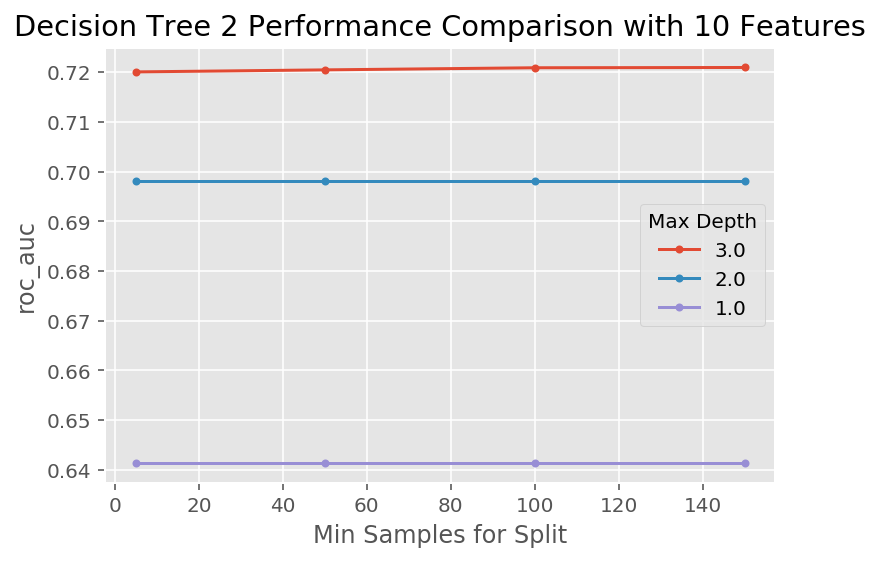

In [88]:
DT2_results_10_features = DT2_results[DT2_results['rfi_fs__n_features_'] == 10.0].sort_values('dt__min_samples_split')


for i in DT2_results_10_features['dt__max_depth'].unique():
    temp = DT2_results_10_features[DT2_results_10_features['dt__max_depth'] == i]
    plt.plot(temp['dt__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "Max Depth")
plt.xlabel('Min Samples for Split')
plt.ylabel("roc_auc")
plt.title("Decision Tree 2 Performance Comparison with 10 Features")
plt.show()

### Random Forest classifier <a name="RF"></a>

The random forest classifier is a model based on the concept of "bagging," with decision trees serving as sub-classifiers. With 100 decision trees, a random forest classifier is fitted.

A pipeline is built to identify the best parameters for the RFI and RFC models. When utilising the RFC model, RFI is fitted to identify the appropriate amount of features. DT's maximum depth is set to 5,6,7,8, and 9. The minimum sample split is set to 2 and 5.

In [89]:
from sklearn.ensemble import RandomForestClassifier
pipe_rf = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('rf', RandomForestClassifier(n_estimators=100))])

params_pipe_rf = {'rfi_fs__n_features_': [5, 10,15, Data.shape[1]],
                  'rf__max_depth': [5,6,7,8,9],
                  'rf__min_samples_split': [2, 5]}

gs_pipe_rf = GridSearchCV(estimator=pipe_rf, 
                          param_grid=params_pipe_rf, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_rf.fit(Data_train, target_train);




Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed: 17.1min finished


The ideal number of features using the RFC model is 23 with Max-depth as 8

In [91]:
gs_pipe_rf.best_params_

{'rf__max_depth': 8, 'rf__min_samples_split': 5, 'rfi_fs__n_features_': 23}

The performance score for 23 number of features is 0.779.

In [92]:
gs_pipe_rf.best_score_

0.7796036803181826

Below is a dataframe grid showing all the ideal settings, along with their performance score.

In [95]:
RF_results = get_search_results(gs_pipe_rf)
RF_results.head()

,mean_score,std_score,max_score,min_score,rf__max_depth,rf__min_samples_split,rfi_fs__n_features_
31,0.779604,0.005189,0.782806,0.769288,8.0,5.0,23.0
27,0.779296,0.004151,0.782761,0.771392,8.0,2.0,23.0
39,0.778769,0.004052,0.782555,0.771030,9.0,5.0,23.0
35,0.778692,0.004530,0.782951,0.769916,9.0,2.0,23.0
19,0.778148,0.004638,0.781019,0.768925,7.0,2.0,23.0


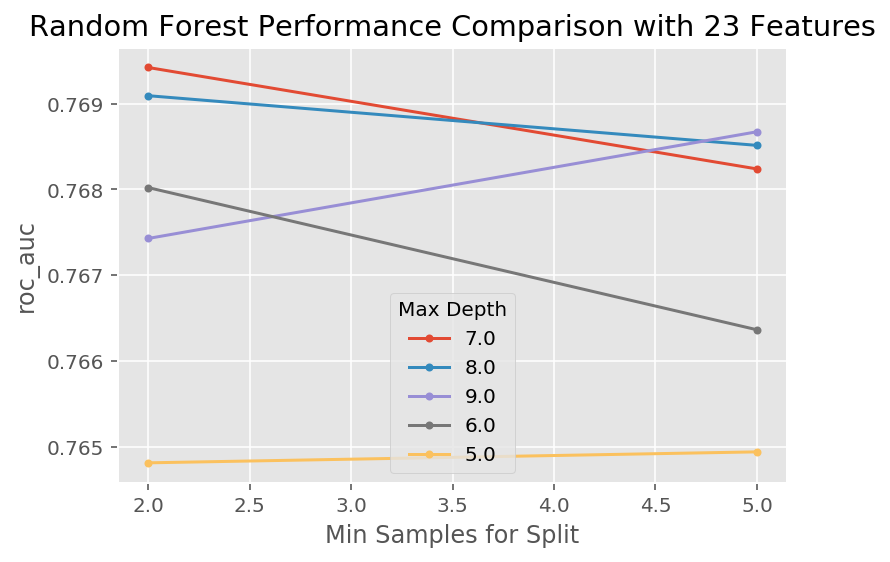

In [96]:
RF_results_10_features = RF_results[RF_results['rfi_fs__n_features_'] == 10.0]


for i in RF_results_10_features['rf__max_depth'].unique():
    temp = RF_results_10_features[RF_results_10_features['rf__max_depth'] == i]
    plt.plot(temp['rf__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "Max Depth")
plt.xlabel('Min Samples for Split')
plt.ylabel("roc_auc")
plt.title("Random Forest Performance Comparison with 23 Features")
plt.show()

A visual representation of the performance score with number of features =10 with varying depth is displayed above.

## Model Comparision <a name="MC"></a>

## Performance Comparison 

The following performance scores are derived from the models

- KNN 0.743
- Logistic Regression 0.712
- Naive Bayes 0.719
- Decision Tree 0.72
- Random Forest Classifier 0.779

It is observed that  Random Forest Classifier has the highest AUC of 0.779. Where the difference is significant or not can be identified by conducting a paired t-test

## Cross-validation 

In [104]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=111)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.7323004294296016

In [105]:
cv_results_LR = cross_val_score(best_lr, Data_test, target_test, scoring = "roc_auc", cv = cv_method_ttest)

cv_results_LR.mean()

0.7117969626766398

In [106]:
cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=Data_test,
                                y=target_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_NB.mean()

0.7171984678333587

In [107]:
cv_results_DT2 = cross_val_score(estimator=gs_pipe_DT2.best_estimator_,
                                X=Data_test,
                                y=target_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT2.mean()

0.7226646027928515

In [108]:
cv_results_rf = cross_val_score(estimator=gs_pipe_rf.best_estimator_,
                                X=Data_test,
                                y=target_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_rf.mean()


0.7737657570612385

According to the above performance results, the Random Forest Classifier has same better rate of prediction.

## Paired t-test for model comparison

A paired t-test is performed on prediction models to determine whether or not their performance is statistically significant. If the p-value is less than 0.05, the models are statistically significant; if it is greater than 0.05, the models are not statistically significant at the 95 percent level of significance.

Random Forest has the greatest score of the models discussed above, thus it is compared against the other models to see if they are statistically significant. The t-test is performed using the stats.ttest rel function in the scipy package.

In [109]:
from scipy import stats

print(stats.ttest_rel(cv_results_rf, cv_results_DT2))
print(stats.ttest_rel(cv_results_rf, cv_results_KNN))
print(stats.ttest_rel(cv_results_rf, cv_results_LR))
print(stats.ttest_rel(cv_results_rf, cv_results_NB))
print(stats.ttest_rel(cv_results_DT2, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT2, cv_results_NB))
print(stats.ttest_rel(cv_results_DT2, cv_results_LR))

Ttest_relResult(statistic=11.523000898780746, pvalue=1.0869452598121867e-06)
Ttest_relResult(statistic=8.687006076770915, pvalue=1.139473648874477e-05)
Ttest_relResult(statistic=9.332957212119947, pvalue=6.336950739788017e-06)
Ttest_relResult(statistic=6.3280354775107925, pvalue=0.00013637323706430535)
Ttest_relResult(statistic=-2.2394189374222444, pvalue=0.05189248177222549)
Ttest_relResult(statistic=0.6611867255870284, pvalue=0.525055388494238)
Ttest_relResult(statistic=1.7654866155046385, pvalue=0.1112957789297061)


The t-test results reveal that there is no statistically significant difference between the Decision Tree and Random Forest classifiers and the other models. Random Forest will be chosen as the best model. 

Despite the fact that Accuracy was used to improve the algorithm hyperparameters, we will utilise the following metrics to assess models based on the test set:
- Precision
- Recall
- F1 Score (the harmonic average of precision and recall)
- Confusion Matrix
These metrics may be calculated with sklearn.metrics' classification report. The categorisation reports are displayed in the table below.

In [110]:
pred_KNN = gs_pipe_KNN.predict(Data_test)

In [111]:
pred_LR = best_lr.predict(Data_test)

In [112]:
pred_NB = gs_pipe_NB.predict(Data_test)

In [113]:
pred_DT = gs_pipe_DT2.predict(Data_test)

In [114]:
pred_rf=gs_pipe_rf.predict(Data_test)


### Classification Report

In [115]:
from sklearn import metrics
print("\nConfusion matrix for Logistic Regression") 
print(metrics.classification_report(target_test, pred_LR))
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_test, pred_KNN))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(target_test, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(target_test, pred_DT))
print("\nConfusion matrix for Random Forest Classifier") 
print(metrics.classification_report(target_test, pred_rf))


Confusion matrix for Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      7009
           1       0.71      0.18      0.29      1991

    accuracy                           0.80      9000
   macro avg       0.76      0.58      0.59      9000
weighted avg       0.79      0.80      0.75      9000


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7009
           1       0.65      0.32      0.43      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.63      0.66      9000
weighted avg       0.79      0.81      0.79      9000


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7009
           1       0.73      0.01      0.02      1991

    accuracy                           0.78      9000
 

### Confusion Matrix

In [116]:
from sklearn import metrics
print("\nConfusion matrix for Logistic Regression") 
print(metrics.confusion_matrix(target_test, pred_LR))
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_test, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(target_test, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(target_test, pred_DT))
print("\nConfusion matrix for Random Forest Classifier") 
print(metrics.confusion_matrix(target_test, pred_rf))


Confusion matrix for Logistic Regression
[[6856  153]
 [1624  367]]

Confusion matrix for K-Nearest Neighbor
[[6675  334]
 [1363  628]]

Confusion matrix for Naive Bayes
[[7003    6]
 [1975   16]]

Confusion matrix for Decision Tree
[[6765  244]
 [1341  650]]

Confusion matrix for Random Forest Classifier
[[6684  325]
 [1283  708]]


Both Decision Tree and Random Forestshows similar performance. The confusion matrices are in line with the classification reports. This is in contrast to our finding that Random Forest is statistically the best performer when it comes to the AUC and Accuracy metric. Navive Bayes has the best recall score where we might say that it produces highest recall score for clients with no defaults. 

# Critique & Limitations <a name="CL"></a>

Our modelling technique is not without errors and limits. We used a black-box strategy since we valued raw predictive performance over interpretability. The Random Forest classifier outperforms the other models statistically. As a result, we may be able to enhance it by broadening the hyperparameter search field and integrating more parameters of this classification approach. Furthermore, DT and other ensemble approaches based on trees might be considered as possibly superior models.In the future, we may think about doing a more in-depth examination of the feature selection and ranking process, as well as our hyperparameter space selections. When creating the NB, we used a blanket power transformation on the training data, disregarding the fake features in the dataset. This might account for some of the NB's low performance on the test set. A possible method is to construct a Gaussian NB and a Bernoulli NB independently on the numerical and dummy descriptive characteristics. Because NB assumes inter-independence conditioned on the value of the target feature, we may calculate a final prediction by multiplying predictions from each model. 

# Summary & Conclusions <a name="SC"></a>



## Project Summary <a name="PS"></a>

In Phase I, the project's goal was to perform data preprocessing on Taiwan's Credit Card Customer defaults data by dropping ID column, checking the dataypes and missing values, visualising Univariate, Biavariate and Multivariate data and explore the data to gain a better understanding of all the Demographic and Financial variables' impact on the clients' default payments in Taiwan, and identify the key drivers that determine its likelihood. <br>

Using the findings and data collected in Phase I, target feature was defined, data was further transformed using Min-Max Scaling for machine learning. Optimum features were selected using the Random Forest information feature selection method. Then 5-fold stratified cross-validation was executed using feature selection and hyperparameter serach inside a single pipeline. Dataset was then split inyo 70:30 ratio in training and testing data. Models: K-Nearest Neighbours (KNN),  Logistic Regression (LR), Decision Trees (DT), Naive Bayes (NB), and Random Forest Classifier (RF) were established and created to assess the predicted accuracy of probability of defaults on credit data using various categorisation methods in Phase II.

## Summary of Findings <a name="SF"></a>

From the project we found from visualising the data that in Taiwan, there are more female credit clients than male credit clients. University students are more likely to default than graduates and high school students. The number of credit card users is highest between the ages of 25 and 40, but steadily declines, indicating that as people become older, they use less credit cards.
By implementing various machine learning models on the pre-processed and transformed data we found that Decision Tree and Random Forest Classifier have a very slight difference in their model perfomance accuracy score. However, Random Forest outperforms Decision Tree model in ROC-AUC score. Further, a paired t-test is performed to check it’s performance whether they are statistically significant or not. However, we saw that there is still no significant difference between Decision Tree and Random Forest classifier models. They both shows better performance score comapred to other models. So, a classification report and confusion matrix is build. 

## Conclusions <a name="C"></a>

On the training data, the Random Forest Classifier with 10 of the best features chosen by Random Forest Importance (RFI) achieve the greatest cross-validated Accuracy score. Furthermore, when tested on test data (in a cross-validated method), the random forest classifier model again exceeds all other models in terms of AUC. On the test data, however, the Naive Bayes model produces the greatest recall score. We saw that in terms of accuracy, both Decision Tree and Random Forest turns out to be equal performer. We also see that when conditioned on the values of the hyperparameters in general, our models are not very sensitive to the number of features chosen by RFI. As a consequence, it appears that working with 10 features is better to working with the entire feature set, perhaps avoiding overfitting and resulting in irrational outcomes. Decision Tree intakes 10 features with max depth of 3 whereas Random Forest model results in max depth of 8 and 23 features. Since there is not a huge differenve between these two models, we can also say that Decision Tree model might work better as it uses less features. 

# References <a name="R"></a>

- Taiwan’s cash-card write-offs hit record high [Review of Taiwan’s cash-card write-offs hit record high].<a name="1"></a>
- Wang, E. (n.d.). Review of Taiwan’s Credit Card Crisis https://sevenpillarsinstitute.org/case-studies/taiwans-credit-card-crisis/<a name="2"></a>
- Financial Times. https://www.ft.com/content/8c9e45e2-2f47-11da-8b51-00000e2511c8<a name="3"></a>
- UCI Machine Learning Repository: default of credit card clients Data Set. (2016). Uci.edu. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
- Default of Credit Card Clients Dataset. (n.d.). Kaggle.com. https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset
- Aksakalli, Vural, Babak Abbasi, and Yong Kai Wong. 2018. SpFSR: Feature Selection and Ranking by Simultaneous Perturbation Stochastic Approximation.https://github.com/vaksakalli/spFSR